In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:

# Step 1: Load CSV Data
data = pd.read_csv('/content/drive/MyDrive/Th/5k_data.csv')

New

In [39]:
# Step 2: Preprocess the data
X = data.drop('Recurred', axis=1)
y = data['Recurred'].map({'Yes': 1, 'No': 0})

categorical_cols = ['Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function',
                    'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage']
numerical_cols = ['Age']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

X_processed = preprocessor.fit_transform(X)

In [40]:
# Step 3: Non-IID Data Partitioning
def split_non_iid(data, labels, num_clients):
    grouped_data = {}
    for label in np.unique(labels):
        indices = np.where(labels == label)[0]
        grouped_data[label] = np.array_split(indices, num_clients)

    client_data = {i: [] for i in range(num_clients)}
    for label, splits in grouped_data.items():
        for i, split in enumerate(splits):
            client_data[i].extend(split)

    return [
        (data[client_data[i]], labels[client_data[i]]) for i in range(num_clients)
    ]

num_clients = 3
client_data = split_non_iid(X_processed, y.values, num_clients)

# Dataset class
class CSV_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.toarray(), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

clients = [CSV_Dataset(features, labels) for features, labels in client_data]

In [41]:
# Model definition
class FederatedNet(nn.Module):
    def __init__(self, input_dim):
        super(FederatedNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_parameters(self):
        return {name: param.data.clone() for name, param in self.named_parameters()}

    def set_parameters(self, parameters):
        for name, param in self.named_parameters():
            param.data.copy_(parameters[name])


In [42]:
# Helper functions
def aggregate_parameters(client_params, num_clients):
    aggregated = {name: torch.zeros_like(param) for name, param in client_params[0].items()}
    for client_param in client_params:
        for name in aggregated:
            aggregated[name] += client_param[name] / num_clients
    return aggregated

def evaluate_model(model, dataset, device):
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

In [43]:
from sklearn.model_selection import ParameterGrid

# Federated Learning with Hyperparameter Tuning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = FederatedNet(input_dim=X_processed.shape[1]).to(device)

# Hyperparameter tuning (learning_rate, epochs_per_client)
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs_per_client': [5, 10, 15]
}

# Create a list of all parameter combinations
param_combinations = list(ParameterGrid(param_grid))

# History to store the results of each combination
history = []

# Perform hyperparameter tuning
best_val_acc = 0
best_params = {}

for params in param_combinations:
    print(f"Training with hyperparameters: {params}")

    # Initialize the global model
    global_model = FederatedNet(input_dim=X_processed.shape[1]).to(device)

    # Set the current combination of hyperparameters
    learning_rate = params['learning_rate']
    epochs_per_client = params['epochs_per_client']

    # Training loop
    for round_idx in range(num_rounds):
        client_params = []
        for client_idx, client_dataset in enumerate(clients):
            model = FederatedNet(input_dim=X_processed.shape[1]).to(device)
            model.set_parameters(global_model.get_parameters())

            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            dataloader = DataLoader(client_dataset, batch_size=128, shuffle=True)

            model.train()
            for _ in range(epochs_per_client):
                for features, labels in dataloader:
                    features, labels = features.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(features)
                    loss = nn.CrossEntropyLoss()(outputs, labels)
                    loss.backward()
                    optimizer.step()

            client_params.append(model.get_parameters())

        # Aggregate client parameters
        aggregated_params = aggregate_parameters(client_params, num_clients)
        global_model.set_parameters(aggregated_params)

        # Evaluate global model on each client's data (train and validation)
        train_acc = evaluate_model(global_model, clients[0], device)
        validation_acc = evaluate_model(global_model, clients[1], device)  # Renamed to 'validation'

        print(f"Round {round_idx + 1}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {validation_acc:.4f}")

        # Store the best hyperparameters based on validation accuracy
        if validation_acc > best_val_acc:
            best_val_acc = validation_acc
            best_params = params

    # Save the best model parameters after hyperparameter search
    history.append((best_params, best_val_acc))

# Output the best hyperparameters and validation accuracy
print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_val_acc)


Training with hyperparameters: {'epochs_per_client': 5, 'learning_rate': 0.001}
Round 1: Train Accuracy = 0.8902, Validation Accuracy = 0.8992
Round 2: Train Accuracy = 0.8992, Validation Accuracy = 0.9046
Round 3: Train Accuracy = 0.9004, Validation Accuracy = 0.9046
Round 4: Train Accuracy = 0.9004, Validation Accuracy = 0.9064
Round 5: Train Accuracy = 0.9016, Validation Accuracy = 0.9076
Round 6: Train Accuracy = 0.9010, Validation Accuracy = 0.9058
Round 7: Train Accuracy = 0.9010, Validation Accuracy = 0.9106
Round 8: Train Accuracy = 0.9028, Validation Accuracy = 0.9106
Round 9: Train Accuracy = 0.9046, Validation Accuracy = 0.9112
Round 10: Train Accuracy = 0.9046, Validation Accuracy = 0.9106
Round 11: Train Accuracy = 0.9064, Validation Accuracy = 0.9118
Round 12: Train Accuracy = 0.9058, Validation Accuracy = 0.9094
Round 13: Train Accuracy = 0.9058, Validation Accuracy = 0.9124
Round 14: Train Accuracy = 0.9070, Validation Accuracy = 0.9076
Round 15: Train Accuracy = 0.9064

In [44]:
# Training with the Best Hyperparameters (epochs_per_client=5, learning_rate=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = FederatedNet(input_dim=X_processed.shape[1]).to(device)

# Best hyperparameters
learning_rate = 0.01
epochs_per_client = 5

history = []  # Initialize the history list to store accuracies

# Training loop
for round_idx in range(num_rounds):
    client_params = []
    for client_idx, client_dataset in enumerate(clients):
        model = FederatedNet(input_dim=X_processed.shape[1]).to(device)
        model.set_parameters(global_model.get_parameters())

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        dataloader = DataLoader(client_dataset, batch_size=128, shuffle=True)

        model.train()
        for _ in range(epochs_per_client):
            for features, labels in dataloader:
                features, labels = features.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(features)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                loss.backward()
                optimizer.step()

        client_params.append(model.get_parameters())

    # Aggregate client parameters
    aggregated_params = aggregate_parameters(client_params, num_clients)
    global_model.set_parameters(aggregated_params)

    # Evaluate global model on each client's data (train and validation)
    train_acc = evaluate_model(global_model, clients[0], device)
    validation_acc = evaluate_model(global_model, clients[1], device)  # Renamed to 'validation'

    # Print the accuracies for each round
    print(f"Round {round_idx + 1}: Train Accuracy = {train_acc:.4f}, Validation Accuracy = {validation_acc:.4f}")

    # Append the accuracies as tuples to the history
    history.append((train_acc, validation_acc))


Round 1: Train Accuracy = 0.9010, Validation Accuracy = 0.9058
Round 2: Train Accuracy = 0.8974, Validation Accuracy = 0.9070
Round 3: Train Accuracy = 0.9046, Validation Accuracy = 0.9064
Round 4: Train Accuracy = 0.9052, Validation Accuracy = 0.9136
Round 5: Train Accuracy = 0.9142, Validation Accuracy = 0.9148
Round 6: Train Accuracy = 0.9130, Validation Accuracy = 0.9190
Round 7: Train Accuracy = 0.9172, Validation Accuracy = 0.9208
Round 8: Train Accuracy = 0.9154, Validation Accuracy = 0.9160
Round 9: Train Accuracy = 0.9130, Validation Accuracy = 0.9220
Round 10: Train Accuracy = 0.9172, Validation Accuracy = 0.9238
Round 11: Train Accuracy = 0.9220, Validation Accuracy = 0.9214
Round 12: Train Accuracy = 0.9232, Validation Accuracy = 0.9250
Round 13: Train Accuracy = 0.9268, Validation Accuracy = 0.9268
Round 14: Train Accuracy = 0.9292, Validation Accuracy = 0.9250
Round 15: Train Accuracy = 0.9322, Validation Accuracy = 0.9298
Round 16: Train Accuracy = 0.9310, Validation Acc

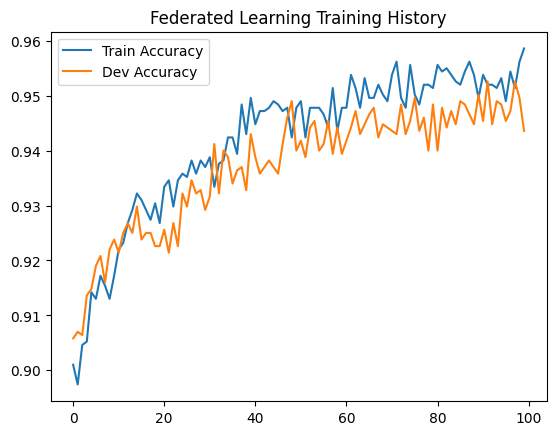

In [45]:
# Plot training history
plt.plot([h[0] for h in history], label='Train Accuracy')
plt.plot([h[1] for h in history], label='Dev Accuracy')
plt.legend()
plt.title('Federated Learning Training History')
plt.show()

In [50]:
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
# Create a dataloader for the test dataset
test_dataloader = DataLoader(clients[2], batch_size=128, shuffle=False)

# Predictions and true labels for classification report
y_true = []
y_pred = []

# Set the model to evaluation mode
global_model.eval()

# Iterate through the test data
with torch.no_grad():
    for features, labels in test_dataloader:
        features, labels = features.to(device), labels.to(device)
        outputs = global_model(features)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate and print the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       962
           1       0.95      0.92      0.94       704

    accuracy                           0.95      1666
   macro avg       0.95      0.94      0.95      1666
weighted avg       0.95      0.95      0.95      1666



In [49]:
# Print final accuracy
final_train_acc = history[-1][0]  # Last training accuracy
final_validation_acc = history[-1][1]  # Last validation accuracy

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_validation_acc:.4f}")

Final Training Accuracy: 0.9586
Final Validation Accuracy: 0.9436


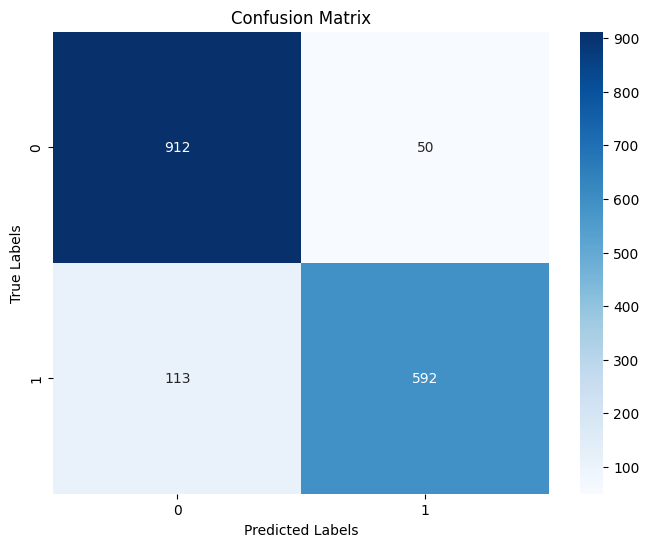

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Evaluate global model on the final dataset (validation or test dataset)
final_dataset = clients[1]  # Assuming the second client is used for validation
model.eval()  # Set model to evaluation mode

# Collect true labels and predictions
true_labels = []
predicted_labels = []

with torch.no_grad():
    for features, labels in DataLoader(final_dataset, batch_size=128, shuffle=False):
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
